In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from bisect import bisect
import copy
from itertools import chain
from collections import Counter
import networkx as nx
import math
import seaborn as sns

In [15]:
# 2023-01-31 Changes
# 1. Change fully_connected function to dictionary format

# Create a class that contains a network of agents
class Network():

    def __init__(self, n_agents, continuum=[0,1],cur_sim = 0, dmin=0.1,m=2,dictionary=5000,weights=5000):
        self.n_agents = n_agents
        self.continuum = continuum
        self.dmin = dmin
        self.M = m
        self.cur_sim = cur_sim
        
        if dictionary != None:
            self.dictionary = dictionary
            self.weights = weights
        else:
            self.dictionary = [str(i) for i in range(dictionary)]
            self.weights = [1/weights for i in range(weights)]
        self.neighbors = []

        
        self.agents = []
        self.agents_cats = {}
        self.agents_labs = {}
        self.agents_successes = {}
        self.agents_neigh = {}
        
        self.speakers = []
        self.sim_n = []
        self.hearers = []
        self.scenes = []
        self.topics = []
        self.said = []
        self.hearer_guesses = []
        self.outcomes = []

        self.t_players = 0
        self.t_scene = 0
        self.t_discriminate = 0
        self.t_play_round = 0

    # Identical to play-round but exhausts list (in random order) of agents and randomly chooses partner from the neighbors, randomly assigns roles.
    def play_round_all(self, n = None): # if n is none, iterates through all agents, else completes n rounds of play
        
        # Different part: iterate through all agents, randomly select neighbor, randomly assign roles
        all_rand = []
        if n is None:
            all_rand = [i for i in range(self.n_agents)]
            random.shuffle(all_rand)
        else:
            all_rand = random.choices(range(self.n_agents), k=n)
        for s in all_rand:
            s = 'A_'+str(s)
            h = random.choice(self.agents_neigh[s])
            pair = [s,h]
            random.shuffle(pair)
            speaker = pair[0]
            hearer = pair[1]
        
            # Same as play_round
            scene = set()
            while len(scene) < 3:
                object = random.random() 
                if all(abs(object - other) >= self.dmin for other in scene):
                    scene.add(object)
            scene = sorted(scene)
            topic = random.choice(scene)

            self.descriminate(scene, topic, speaker)
            
            cat = bisect(self.agents_cats[speaker], topic)
            if 1 in self.agents_successes[speaker][cat]:
                word = self.agents_labs[speaker][cat][-1] # The success will always be the last word in the list
            else:
                word = self.agents_labs[speaker][cat][0]
            categories_scene = [bisect(self.agents_cats[hearer], c) for c in scene]
            indices = list(set([i for i, x in enumerate(self.agents_labs[hearer]) if word in x]) & set(categories_scene))
            success = False
            if len(indices) > 0:
                guess = scene[categories_scene.index(random.choice(indices))]
                self.hearer_guesses.append(guess)
                if guess == topic:
                    success = True
            else:
                self.hearer_guesses.append(None)
            self.speakers.append(speaker)
            self.hearers.append(hearer)
            self.scenes.append(scene)
            self.topics.append(topic)
            self.said.append(word)
            self.outcomes.append(success)
            self.sim_n.append(self.cur_sim)
            self.descriminate(scene, topic, hearer)
            if success:
                self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)] = [word]
                self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)] = [1]
                self.agents_labs[speaker][bisect(self.agents_cats[speaker], topic)] = [word]
                self.agents_successes[speaker][bisect(self.agents_cats[speaker], topic)] = [1]
            else:
                self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)] = [word] + self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)]
                self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)] = [0] + self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)]


    # Descriminate scene if necessary, adding new category boundaries to isolate the topic; then she labels one object and the hearer tries to guess it
    # Each new categoryinherits the linguistic inventory of C, plus a new word.   
    def descriminate(self,scene, topic, person):
        categories_scene = [bisect(self.agents_cats[person], c) for c in scene]
        if len(set(categories_scene)) == len(categories_scene):
            return # The topic is already descriminated

        # If the topic is the smallest, and doesn't descriminate, add a new category halfway between it and second with the same labels
        elif scene.index(topic) == 0:
            if categories_scene[0] == categories_scene[1]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2) # Change here (and all other casaes of word_1) previously random.choices produced one unique item for word_1 and word_2 separately
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[0], (scene[0]+scene[1])/2)
                self.agents_labs[person].insert(categories_scene[0],[word_1] + self.agents_labs[person][categories_scene[0]])
                self.agents_successes[person].insert(categories_scene[0],[0] + self.agents_successes[person][categories_scene[0]])
                self.agents_labs[person][categories_scene[0]+1] = [word_2] + self.agents_labs[person][categories_scene[0]+1]
                self.agents_successes[person][categories_scene[0]+1] = [0] + self.agents_successes[person][categories_scene[0]+1]

        # If the topic is the largest, and doesn't descriminate, add a new category halfway between it and second to last with the same labels
        elif scene.index(topic) == len(scene) - 1:
            if categories_scene[-1] == categories_scene[-2]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2)
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[-1], (scene[-1]+scene[-2])/2)
                self.agents_labs[person].insert(categories_scene[-1],[word_1] + self.agents_labs[person][categories_scene[-1]])
                self.agents_successes[person].insert(categories_scene[-1],[0] + self.agents_successes[person][categories_scene[-1]])
                self.agents_labs[person][categories_scene[-1]+1] = [word_2] + self.agents_labs[person][categories_scene[-1]+1]
                self.agents_successes[person][categories_scene[-1]+1] = [0] + self.agents_successes[person][categories_scene[-1]+1]
        
        # if the topic is in the middle, and doesn't descriminate, add a new category halfway between it and the undescriminated partners with the same labels
        elif scene.index(topic) > 0 and scene.index(topic) < len(scene) - 1:
            # If need to descriminate twice, update twice
            if (categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)-1]) and (categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)+1]):
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=3)
                    if len(set(pos_words)) == 3 : 
                        word_1, word_2, word_3 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)+1])/2)
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)-1])/2)
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]])
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]+1])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],[0] + self.agents_successes[person][categories_scene[scene.index(topic)]])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],[0] + self.agents_successes[person][categories_scene[scene.index(topic)]+1])
                self.agents_labs[person][categories_scene[scene.index(topic)]+2] = [word_3] + self.agents_labs[person][categories_scene[scene.index(topic)]]  
                self.agents_successes[person][categories_scene[scene.index(topic)]+2] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]+1] = [word_2] + self.agents_labs[person][categories_scene[scene.index(topic)]]  
                self.agents_successes[person][categories_scene[scene.index(topic)]+1] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]] = [word_1] + self.agents_labs[person][categories_scene[scene.index(topic)]]  
                self.agents_successes[person][categories_scene[scene.index(topic)]] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
        
            # If need to descriminate once, update once
            elif categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)-1]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2)
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)-1])/2)
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],[0] + self.agents_successes[person][categories_scene[scene.index(topic)]])
                self.agents_labs[person][categories_scene[scene.index(topic)]+1] = [word_2] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]+1] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]] = [word_1] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
            elif categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)+1]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2)
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)+1])/2)
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],self.agents_successes[person][categories_scene[scene.index(topic)]])
                self.agents_labs[person][categories_scene[scene.index(topic)]+1] = [word_2] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]+1] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]] = [word_1] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]


    # Return a dataframe with all of the rounds played
    def get_data(self):
        return pd.DataFrame({'Speaker':self.speakers, 'Hearer':self.hearers, 'Scene':self.scenes, 'Topic':self.topics, 'Said':self.said, 
                                'Hearer_guesses':self.hearer_guesses, 'Outcome':self.outcomes,'Sim_N':self.sim_n})

     # Types of networks
    def fully_connected(self):
        # All players are created with only the trivial perceptual category [0,1], with no label associated to it
        self.agents_cats = {f"A_{i}": [max(self.continuum)] for i in range(self.n_agents)}
        self.agents_labs = {f"A_{i}": [[]] for i in range(self.n_agents)}
        self.agents_successes = {f"A_{i}": [[]] for i in range(self.n_agents)}
        self.agents = [f"A_{i}" for i in range(self.n_agents)]
        self.agents_neigh = {self.agents[i]: self.agents[:i] + self.agents[i+1:] for i in range(len(self.agents))}

    def centralized(self):
        # All players are created with only the trivial perceptual category [0,1], with no label associated to it
        self.agents_cats = {f"A_{i}": [max(self.continuum)] for i in range(self.n_agents)}
        self.agents_labs = {f"A_{i}": [[]] for i in range(self.n_agents)}
        self.agents_successes = {f"A_{i}": [[]] for i in range(self.n_agents)}
        self.agents = [f"A_{i}" for i in range(self.n_agents)]
        self.agents_neigh = {self.agents[i+1]: [self.agents[0]] for i in range(len(self.agents)-1)}
        self.agents_neigh[self.agents[0]] = self.agents[1:]

    # Synonymy is a measure of the average number of words per perceptual category
    def get_synonymy(self):
        synonymy = []
        for a in self.agents:
            synonymy.append(sum([len(i) for i in self.agents_labs[a]]) / len(self.agents_cats[a]))
        return(sum(synonymy)/len(synonymy))

    def get_categories(self):
        cats = []
        for a in self.agents:
            cats.append(len(self.agents_cats[a]))
        return(sum(cats)/len(cats))
    
    def get_linguistic_categories(self):
        cats = []
        for a in self.agents:
            cats.append(len(list(set([l[0] for l in self.agents_labs[a]]))))
        return(sum(cats)/len(cats))

    def get_perceptual_alignment(self):
        align = []
        # Pair every agent with every other agent once
        for a in range(self.n_agents-1):
            a_1 = [0]+ self.agents_cats[self.agents[a]]
            for j in range(self.n_agents-1-a):
                a_2 = [0]+ self.agents_cats[self.agents[a+j+1]]
                # Create a new agent that has all the categories
                a_3 = copy.deepcopy(a_1)
                [a_3.append(i) for i in a_2]
                a_3 = list(set(a_3))
                a_3.sort()
                # Perform the equation on these categories
                a1,a2,a3 = 0,0,0
                for i in range(len(a_1)-1):
                    a1 = a1 + (a_1[i+1] - a_1[i])**2
                for i in range(len(a_2)-1):
                    a2 = a2 + (a_2[i+1] - a_2[i])**2
                for i in range(len(a_3)-1):
                    a3 = a3 + (a_3[i+1] - a_3[i])**2
                align.append((2*a3)/(a1+a2))
        return((2* sum(align)) / (self.n_agents*(self.n_agents-1)))

    def get_linguistic_alignment(self):
        align = []
        # Pair every agent with every other agent once
        for a in range(self.n_agents-1):
            # Get linguistic categories - first item associated with each perceptual category
            a_1 = [l[0] for l in self.agents_labs[self.agents[a]]]
            al_1 = []
            # For each unique item, return last occurence index
            for i in list(set(a_1)):
                al_1.append(len(a_1) - 1 - a_1[::-1].index(i))
            # Get the perceptual category limit associated with each of these and create a composite agent
            a_1 = [0] + [self.agents_cats[self.agents[a]][l] for l in al_1]
            a_1.sort()
            for j in range(self.n_agents-a-1):
                a_2 = [l[0] for l in self.agents_labs[self.agents[a+j+1]]]
                al_2 = []
                for i in list(set(a_2)):
                    al_2.append(len(a_2) - 1 - a_2[::-1].index(i))
                a_2 = [0] + [self.agents_cats[self.agents[a+j+1]][l] for l in al_2]    
                a_2.sort()
                a_3 = copy.deepcopy(a_1)
                [a_3.append(i) for i in a_2]
                a_3 = list(set(a_3))
                a_3.sort()
                # Get the alignment just like we did for the conceptual category
                a1,a2,a3 = 0,0,0
                for i in range(len(a_1)-1):
                    a1 = a1 + (a_1[i+1] - a_1[i])**2
                for i in range(len(a_2)-1):
                    a2 = a2 + (a_2[i+1] - a_2[i])**2
                for i in range(len(a_3)-1):
                    a3 = a3 + (a_3[i+1] - a_3[i])**2
                align.append((2*a3)/(a1+a2))
        return((2* sum(align)) / (self.n_agents*(self.n_agents-1)))


In [3]:
# Create a unifrom and zipf distribution
n_words = 5000
all_words = [str(i) for i in range(n_words)]
uniform_probs = []
zipf_probs = []

for w in range(len(all_words)):
    word = all_words[w]
    uniform_probs.append(1 / n_words)
    zipf_probs.append((w+1)**-1)

total = sum(zipf_probs)
for w in range(len(zipf_probs)):
    zipf_probs[w] = zipf_probs[w] / total


def get_all_final_labels(agents):
    labels= []
    for a in agents:
        for c in a.category_labels:
            [labels.append(i) for i in c]
    return(list(set(labels)))

def get_jaccard(lolow):
    pairings,similarity,n_1,n_2 = [],[],[],[]

    for l_1 in range(len(lolow)):
        for l_2 in range(len(lolow)):
            if (l_1 == l_2) | ((str(l_1) + '-' + str(l_2)) in pairings) | ((str(l_2) + '-' + str(l_1)) in pairings):
                next
            else:
                pairings.append(str(l_1) + '-' + str(l_2))
                n_1.append(l_1)
                n_2.append(l_2)
                intersection = len(set(lolow[l_1]) & set(lolow[l_2]))
                similarity.append(intersection / (len(lolow[l_1]) + len(lolow[l_2]) - intersection))
    
    df_temp = pd.DataFrame({"Similarity":similarity,"Network1":n_1,"Network2":n_2})
    
    avg_sim = []
    for n in range(len(lolow)):
        avg_sim.append(df_temp.loc[(df_temp.Network1 == n) | (df_temp.Network2 == n)].Similarity.mean())
    
    return(avg_sim)

# Get coords for manual placement on graph
def circle_pos(n_ag):
    stepSize = 2 * math.pi / n_ag
    p = {}
    t,n,r = 0,0,2
    while t < (2 * math.pi):
        p[test.agents[n]] = [r * math.cos(t), r * math.sin(t)]
        t += stepSize
        n += 1
    return p



# 2023-02-13 Generating change over time plot

In [19]:
n_sims = 25
n_agents = 10
dicts = [round(x*.1 + 1,1) for x in range(0,8)]
df = pd.DataFrame({'ID':[],'Jaccard':[],'Rounds':[],'Dict':[],'Network':[]})
start = time.time()

for network_type in ['Fully','Centralized']:
    print(network_type, '- Total Time - ',time.time() - start)
    for d in range(len(dicts)):
        now = time.time()
        # Create a zipf dictionary with specified degree of bias
        all_words = [str(i) for i in range(5000)]
        zipf_probs = []
        for w in range(len(all_words)):
            word = all_words[w]
            zipf_probs.append((w+1)**-dicts[d])
        total = sum(zipf_probs)
        for w in range(len(zipf_probs)):
            zipf_probs[w] = zipf_probs[w] / total

        now_2 = time.time()
        n_id, n_words, rounds_n = [],[],[]
        
        # Run simulations with the specified number of rounds
        test = Network(n_agents,m=2,dmin=.01,dictionary=all_words,weights=zipf_probs)
        if network_type == 'Fully':
            test.fully_connected()
        elif network_type == 'Centralized':
            test.centralized()

        for s in range(n_sims):
            test.cur_sim=s
            tot_rounds = 0
            for n_rounds in [100,900,9000]:#,90000,900000]:
                print(n_rounds)
                tot_rounds+=n_rounds
                test.play_round_all(n=n_rounds)
                df_info = test.get_data()
                df_info = df_info.loc[df_info.Sim_N == s]
                n_id.append(s)
                rounds_n.append(tot_rounds)

                # Top 5 words for finding Jaccard distance
                vocab = []
                for a in test.agents_labs.values():
                    if len(a) == 1:
                        next
                    else:
                        for l in a:
                            vocab.append(l[0])
                c = Counter(vocab)
                n_words.append(list(set([i[0] for i in c.most_common(5)])))


            # Reset network - Necessary if you put the network out of the loop
            test.agents_cats = []
            test.agents_labs = []
            test.agents_successes = []
            test.agents_cats = {f"A_{i}": [max(test.continuum)] for i in range(test.n_agents)}
            test.agents_labs = {f"A_{i}": [[]] for i in range(test.n_agents)}
            test.agents_successes = {f"A_{i}": [[]] for i in range(test.n_agents)}
                
            print('Agents:',n_agents,'Dict:',dicts[d],'Time:',time.time() - now_2)

        df_t = pd.DataFrame({'ID':n_id,'Words':n_words,'Rounds':rounds_n})
        for n_rounds in [100,1000,10000,100000,1000000]:
            df_t2 = df_t.loc[df_t.Rounds == n_rounds]
            jac = get_jaccard(list(df_t.Words))
            df_current = pd.DataFrame({'ID':n_id,'Jaccard':jac})
            df_current['Rounds'] = rounds_n
            df_current['Dict'] = dicts[d]
            df_current['Network'] = network_type
            df = pd.concat([df,df_current])

Fully - Total Time -  0.0008132457733154297
100
900
9000
Agents: 10 Dict: 1.0 Time: 0.4207298755645752
100
900
9000
Agents: 10 Dict: 1.0 Time: 0.8680808544158936
100
900
9000
Agents: 10 Dict: 1.0 Time: 1.4255437850952148
100
900
9000
Agents: 10 Dict: 1.0 Time: 1.8510839939117432
100
900
9000
Agents: 10 Dict: 1.0 Time: 2.3631198406219482
100
900
9000
Agents: 10 Dict: 1.0 Time: 2.9185328483581543
100
900
9000
Agents: 10 Dict: 1.0 Time: 3.4882748126983643
100
900
9000
Agents: 10 Dict: 1.0 Time: 4.113296747207642
100
900
9000
Agents: 10 Dict: 1.0 Time: 4.725509881973267
100
900
9000
Agents: 10 Dict: 1.0 Time: 5.610349655151367
100
900
9000
Agents: 10 Dict: 1.0 Time: 6.397329807281494
100
900
9000
Agents: 10 Dict: 1.0 Time: 7.140488862991333
100
900
9000
Agents: 10 Dict: 1.0 Time: 7.9558069705963135
100
900
9000
Agents: 10 Dict: 1.0 Time: 8.744900703430176
100
900
9000
Agents: 10 Dict: 1.0 Time: 9.553946733474731
100
900
9000
Agents: 10 Dict: 1.0 Time: 10.496490955352783
100
900
9000
Agents

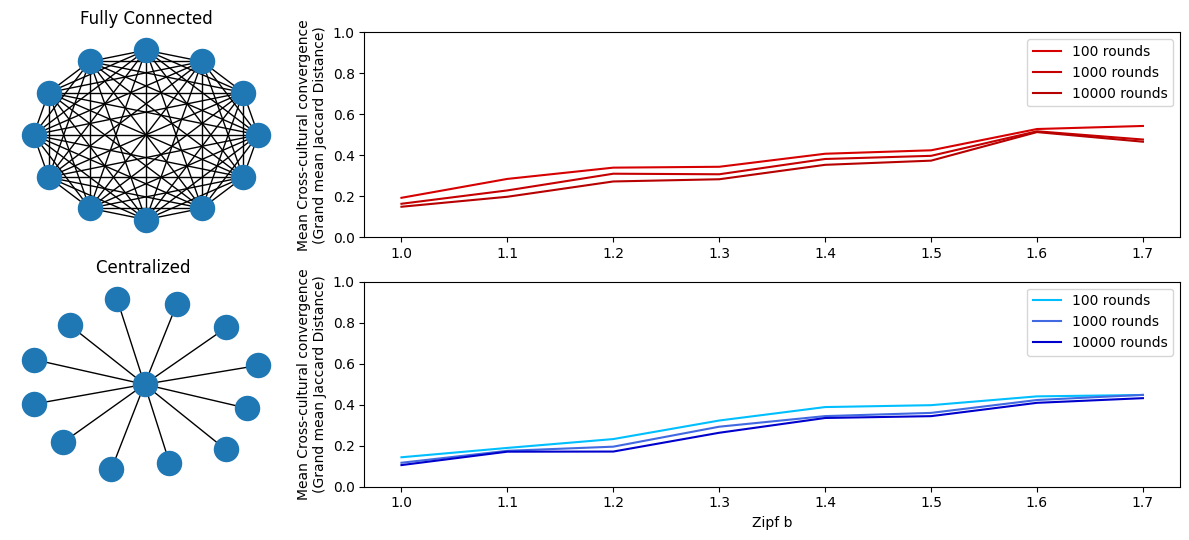

In [24]:
# Group df by dictionary size, then plot
jacs_1, jacs_2 = [[] for i in range(4)],[[] for i in range(4)]
labs = []
rnds = [100,1000,10000]
for i in range(len(rnds)):
    j = rnds[i]
    labs.append(str(j) + ' rounds')
    df_t = df.loc[df.Rounds == j]
    for d in dicts:
        df_temp = df_t.loc[df_t.Dict == d]
        jacs_1[i].append(df_temp.loc[df_temp.Network == 'Fully'].Jaccard.mean())
        jacs_2[i].append(df_temp.loc[df_temp.Network == 'Centralized'].Jaccard.mean())

# Plot these on two figures in two separate rows
fig, axs = plt.subplots(2, 2, figsize=(12, 5.5),gridspec_kw={'width_ratios': [1, 3]})
n_agents = 12

# Plot the network ==============================
# Fully connected
G = nx.complete_graph(n_agents)
nx.draw(G,ax=axs[0,0],pos=nx.circular_layout(G))
axs[0,0].set_title('Fully Connected')
# Centralized
G = nx.star_graph(n_agents)
nx.draw(G,ax=axs[1,0])
axs[1,0].set_title('Centralized ')


# Plot the results ==============================
reds = ['#d70000','#c60000','#b70000','#9b0000','#8b0000']
blues = ['#00bfff','#4169e1','#0000cd','#000080','#00008b']
for i in range(len(reds)-2):
    axs[0,1].plot(dicts,jacs_1[i],'-',color=reds[i],label=labs[i])
    axs[1,1].plot(dicts,jacs_2[i],'-',color=blues[i],label=labs[i])


axs[0,1].set_ylabel('Mean Cross-cultural convergence\n(Grand mean Jaccard Distance)')
axs[1,1].set_ylabel('Mean Cross-cultural convergence\n(Grand mean Jaccard Distance)')
axs[0,1].legend()
axs[1,1].legend()
axs[1,1].set_xlabel('Zipf b')
axs[0,1].set_ylim([0,1])
axs[1,1].set_ylim([0,1])

plt.tight_layout()
plt.show()

In [14]:


vocab = []
for a in test.agents_labs.values():
    if len(a) == 1:
        next
    else:
        for l in a:
            vocab.append(l[0])

# 2023-02-09 Puglisi Plot

In [22]:
# Simulate one round
n_rounds=100000
freq = 10
n_agents = 100

df = pd.DataFrame({'Speaker':[],'Hearer':[],'Scene':[],'Topic':[],'Said':[],'Hearer_guesses':[],'Outcome':[]})
df_syns = pd.DataFrame({'Round':[],'Syns':[],'P_Cats':[],'L_Cats':[],'P_Align':[],'L_Align':[],'D':[]})


for dist in [.1,.01,.001]:
    print(dist)
    test = Network(n_agents,m=2,dmin=dist,dictionary=all_words,weights=zipf_probs)
    test.fully_connected() #test.centralized() 
    syns,p_cats,l_cats,al_p,al_l = [],[],[],[],[]
    rounds = []
    j = 1
    for i in range(n_rounds):
        if i % 200 == 0:
            print(i)
        if (i % freq == 0) and (i != 0):
            if i in [1,3,5,7]:
                rounds.append(i)
                syns.append(test.get_synonymy())
                p_cats.append(test.get_categories())
                l_cats.append(test.get_linguistic_categories())
                al_p.append(test.get_perceptual_alignment())
                al_l.append(test.get_linguistic_alignment())
            elif np.log10(i+1) < j:
                    next
            else:
                j += 0.1
                rounds.append(i)
                syns.append(test.get_synonymy())
                p_cats.append(test.get_categories())
                l_cats.append(test.get_linguistic_categories())
                al_p.append(test.get_perceptual_alignment())
                al_l.append(test.get_linguistic_alignment())
            
        test.play_round_all()

    df_temp = test.get_data() 
    df_temp['D'] = dist
    df = pd.concat([df,df_temp])
    
    df_temp = pd.DataFrame({'Round':rounds,'Syns':syns,'P_Cats':p_cats,'L_Cats':l_cats,'P_Align':al_p,'L_Align':al_l})
    df_temp['D'] = dist
    df_syns = pd.concat([df_syns,df_temp])


0.1
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400
31600
31800
32000
32200
32400
32600
32800
33000
33200
33400
33600
33800
34000
34200
34400
34600
34800
350

/var/folders/q9/lf93qdy52mdg6txk_rbwwp000000gp/T/ipykernel_19140/2842904965.py:43: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,df_temp])


0.01
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800
10000
10200
10400
10600
10800
11000
11200
11400
11600
11800
12000
12200
12400
12600
12800
13000
13200
13400
13600
13800
14000
14200
14400
14600
14800
15000
15200
15400
15600
15800
16000
16200
16400
16600
16800
17000
17200
17400
17600
17800
18000
18200
18400
18600
18800
19000
19200
19400
19600
19800
20000
20200
20400
20600
20800
21000
21200
21400
21600
21800
22000
22200
22400
22600
22800
23000
23200
23400
23600
23800
24000
24200
24400
24600
24800
25000
25200
25400
25600
25800
26000
26200
26400
26600
26800
27000
27200
27400
27600
27800
28000
28200
28400
28600
28800
29000
29200
29400
29600
29800
30000
30200
30400
30600
30800
31000
31200
31400
31600
31800
32000
32200
32400
32600
32800
33000
33200
33400
33600
33800
34000
34200
34400
34600
34800
35

/var/folders/q9/lf93qdy52mdg6txk_rbwwp000000gp/T/ipykernel_19140/2706002509.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Success_100'] = df_temp['Outcome'].rolling(1000).mean()
/var/folders/q9/lf93qdy52mdg6txk_rbwwp000000gp/T/ipykernel_19140/2706002509.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Success_100'] = df_temp['Outcome'].rolling(1000).mean()
/var/folders/q9/lf93qdy52mdg6txk_rbwwp000000gp/T/ipykernel_19140/2706002509.py:18: SettingWithCopyWarning: 
A value is tryin

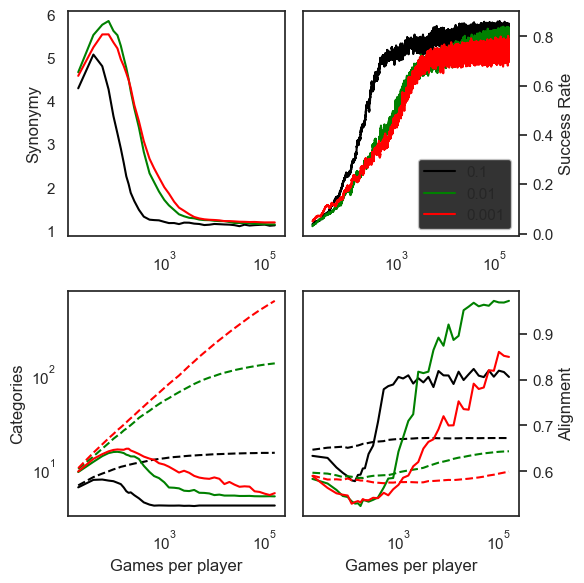

In [24]:
fig, axs = plt.subplots(2,2,figsize=(6,6))
freq = 1000

colors = ['black','green','red']
ds = [.1,.01,.001]

for i in range(len(ds)):
    d = ds[i]
    
    df_temp = df_syns.loc[df_syns['D'] == d]
    axs[0,0].plot(df_temp['Round']*2,df_temp['Syns'],label=str(d),color=colors[i])
    axs[1,0].plot(df_temp['Round']*2,df_temp['P_Cats'],label=str(d),linestyle = '--',color=colors[i])
    axs[1,0].plot(df_temp['Round']*2,df_temp['L_Cats'],label=str(d),linestyle = '-',color=colors[i])
    axs[1,1].plot(df_temp['Round']*2,df_temp['P_Align'],label=str(d),linestyle = '--',color=colors[i])
    axs[1,1].plot(df_temp['Round']*2,df_temp['L_Align'],label=str(d),linestyle = '-',color=colors[i])
    
    df_temp = df.loc[df['D'] == d]
    df_temp['Success_100'] = df_temp['Outcome'].rolling(1000).mean()
    axs[0,1].plot(df_temp.index*.02,df_temp['Success_100'],label=str(d),color=colors[i])

axs[0,1].yaxis.tick_right()
axs[0,1].yaxis.set_label_position("right")
axs[0,0].set_ylabel('Synonymy')
axs[0,0].set_xscale('log')
axs[1,0].set_ylabel('Categories')
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,1].set_ylabel('Alignment')
axs[1,1].set_xscale('log')
axs[1,1].yaxis.tick_right()
axs[1,1].yaxis.set_label_position("right")

axs[0,1].set_ylabel('Success Rate')
axs[0,1].set_xscale('log')
axs[0,1].legend()
axs[1,0].set_xlabel("Games per player")
axs[1,1].set_xlabel("Games per player")
plt.tight_layout()
plt.show()

# 2023-02-05 Generate graphic

In [8]:
n_agents = 50
n_rounds = 5000

df_temp = pd.DataFrame({'Topic':[],'Said':[],'Sim':[]})
words_all = []
now = time.time()
for sim in range(8):
    print(sim,time.time()-now)
    test = Network(n_agents,m=2,dmin=.01,dictionary=all_words,weights=zipf_probs)
    #test.fully_connected()
    test.centralized()
    for j in range(n_rounds):
        test.play_round_all()
    df = test.get_data()

    # Top 5 words
    c = Counter(df.loc[df['Outcome'] == 1].Said)
    words = list(set([i[0] for i in c.most_common(5)]))
    words_all.append(words)
    for w in words:
        df_temp = pd.concat([df_temp, pd.DataFrame({'Topic':df.loc[df['Said'] == w].Topic,'Said':[w for i in range(df.loc[df['Said'] == w].Topic.count())],
                                                'Sim':[sim for i in range(df.loc[df['Said'] == w].Topic.count())]})])

0 0.0009500980377197266
1 17.33330798149109
2 25.157249927520752
3 32.97929906845093
4 40.50163412094116
5 48.790096044540405
6 57.9937789440155
7 67.30663180351257


In [19]:
# Limit to last 100 rounds
df_temp_2 = pd.DataFrame({'Topic':[],'Said':[],'Sim':[]})
for sim in df_temp.Sim.unique():
    df_t = df_temp.loc[df_temp.Sim == sim]
    df_t = df_t.loc[df_t.index > ((n_rounds - 100) * n_agents)]
    for w in df_t.Said.unique():
        df_temp_2 = pd.concat([df_temp_2, df_t.loc[df_t['Said'] == w]])

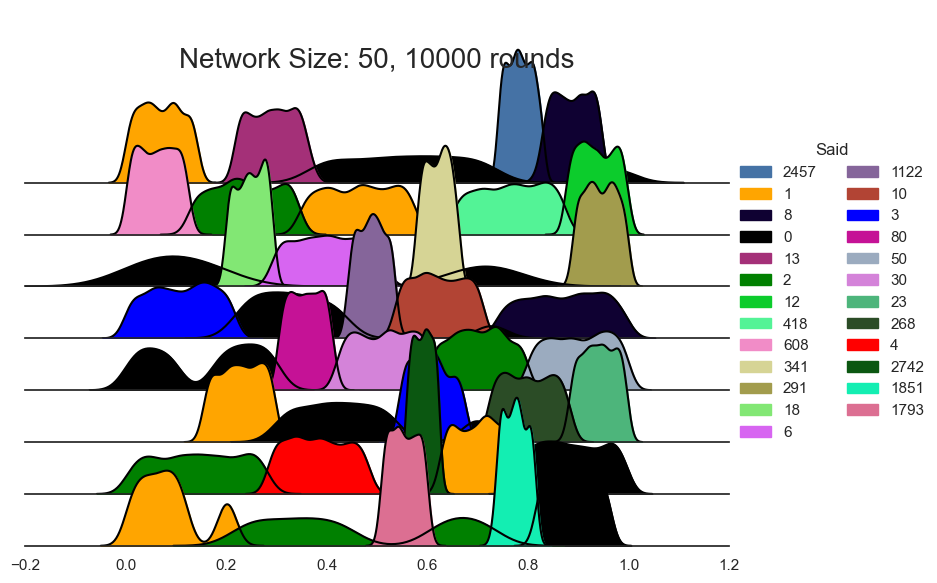

In [21]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
palette = {}
palette_2 = {}

get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

for words in words_all:
    colors = get_colors(len(words))
    for w in words:
        palette[w] = 'black'
        palette_2[w] = colors[words.index(w)]
palette_2['0'] = 'black'
palette_2['1'] = 'orange'
palette_2['2'] = 'green'
palette_2['3'] = 'blue'
palette_2['4'] = 'red'

g = sns.FacetGrid(df_temp_2, row="Sim",hue = "Said", aspect=10, height=0.8,palette=palette_2)
g.map_dataframe(sns.kdeplot, x="Topic",hue = "Said", fill=False, palette=palette)
g.map_dataframe(sns.kdeplot, x="Topic",hue = "Said", fill=True, alpha=1, palette= palette_2)
g.fig.subplots_adjust(hspace=-.7)
g.set_titles("")
g.set_ylabels("")
g.set(yticks=[])
g.despine(left=True)
g.add_legend(ncol=2)

plt.xlabel("")
plt.xlim(-0.2,1.2)
# find the max y value of the plot
plt.text(0.5, 45, 'Network Size: '+str(n_agents)+", "+ str(n_rounds*2)+" rounds", ha='center', va='center',fontsize=20)
plt.show()

# 

In [ ]:
# Simulate one round
n_rounds=2000000
freq = 1000

df = pd.DataFrame({'Speaker':[],'Hearer':[],'Scene':[],'Topic':[],'Said':[],'Hearer_guesses':[],'Outcome':[]})
df_syns = pd.DataFrame({'Round':[],'Syns':[],'P_Cats':[],'L_Cats':[],'P_Align':[],'L_Align':[],'D':[]})


for dist in [.1,.01,.001]:
    print(dist)
    test = Network(100,m=2,dmin=dist,dictionary=10000,weights=10000)
    test.fully_connected()
    syns,p_cats,l_cats,al_p,al_l = [],[],[],[],[]
    rounds = []
    n_words = 100000
    all_words = [str(i) for i in range(n_words)]
    for i in range(n_rounds):
        if i % 50000 == 0:
            print(i)
        if (i % freq == 0) and (i != 0):
            rounds.append(i)
            syns.append(test.get_synonymy())
            p_cats.append(test.get_categories())
            l_cats.append(test.get_linguistic_categories())
            al_p.append(test.get_perceptual_alignment())
            al_l.append(test.get_linguistic_alignment())
        test.play_round()

    df_temp = test.get_data() 
    df_temp['D'] = dist
    df = pd.concat([df,df_temp])
    
    df_temp = pd.DataFrame({'Round':rounds,'Syns':syns,'P_Cats':p_cats,'L_Cats':l_cats,'P_Align':al_p,'L_Align':al_l})
    df_temp['D'] = dist
    df_syns = pd.concat([df_syns,df_temp])

# 2023-02-05 optimize round play

In [13]:
for n_agents in (10,100,1000,10000):
    print(n_agents)
    test = Network(n_agents,m=2,dmin=.01,dictionary=all_words,weights=zipf_probs)
    test.fully_connected()
    
    for j in range(1000):
        test.play_round_all()

    print('Discriminate:',test.t_discriminate)
    print("Generate players",test.t_players)
    print("Scene",test.t_scene)
    print("Play",test.t_play_round)

10
Discriminate: 0.15960454940795898
Generate players 0.03629922866821289
Scene 0.03681445121765137
Play 0.1146085262298584
100
Discriminate: 2.0854551792144775
Generate players 0.33827900886535645
Scene 0.35363078117370605
Play 1.4547028541564941
1000
Discriminate: 30.82520627975464
Generate players 4.186124324798584
Scene 4.044627904891968
Play 22.8853816986084
10000
Discriminate: 389.8509223461151
Generate players 47.23395824432373
Scene 42.72882008552551
Play 291.8998477458954


In [12]:
print('Discriminate:',test.t_discriminate)
print("Generate players",test.t_players)
print("Scene",test.t_scene)
print("Play",test.t_play_round)

Discriminate: 3.165395498275757
Generate players 0.3658411502838135
Scene 0.39861607551574707
Play 1.5802793502807617


In [64]:
# Simulate several networks
n_rounds= 50
n_sims = 1
dicts = [zipf_probs]
df = pd.DataFrame({'ID':[],'Jaccard':[],'Average':[],'Agents':[],'Dict':[]})
n_time, r_time, s_time = [],[],[]
nas = [2,4,8,16,32,64,128,256,512,1024,2048,4096,8192]
now = time.time()
for d in range(len(dicts)):
    for n_agents in nas:
        print(n_agents)
        n_id, n_words, n_avg = [],[],[]
        test = Network(n_agents,m=2,dmin=.01,dictionary=all_words,weights=dicts[d])
        test.fully_connected()
        
        for s in range(n_sims):
            n_time.append(time.time() - now)
            now = time.time()
            test.cur_sim=s
            for i in range(n_rounds):
                test.play_round_all()
            r_time.append(time.time() - now)
            now = time.time()
            
            df_info = test.get_data()
            df_info = df_info.loc[df_info.Sim_N == s]
            n_id.append(s)
            
            says = df_info.groupby("Speaker").apply(lambda x: x.Said.unique())
            hears = df_info.groupby("Hearer").apply(lambda x: x.Said.unique())
            all_ws = [len(set(list(says[i]) + list(hears[i]))) for i in range(len(says))]
            n_avg.append(sum(all_ws) / len(all_ws))

            # Top 5 words
            vocab = []
            for a in test.agents_labs.values():
                vocab = vocab + [l[0] for l in a]
            c = Counter(vocab)
            n_words.append(list(set([i[0] for i in c.most_common(5)])))
            
            s_time.append(time.time() - now)
            now = time.time()
            
            # Reset network
            test.agents_cats = []
            test.agents_labs = []
            test.agents_successes = []
            test.agents_cats = {f"A_{i}": [max(test.continuum)] for i in range(test.n_agents)}
            test.agents_labs = {f"A_{i}": [[]] for i in range(test.n_agents)}
            test.agents_successes = {f"A_{i}": [[]] for i in range(test.n_agents)}
            
            
        jac = get_jaccard(n_words)
        df_current = pd.DataFrame({'ID':n_id,'Jaccard':jac,'Average':n_avg})
        df_current['Agents'] = n_agents
        df_current['Dict'] = d
        df = pd.concat([df,df_current])

2
4
8
16
32
64
128
256
512
1024
2048
4096
8192


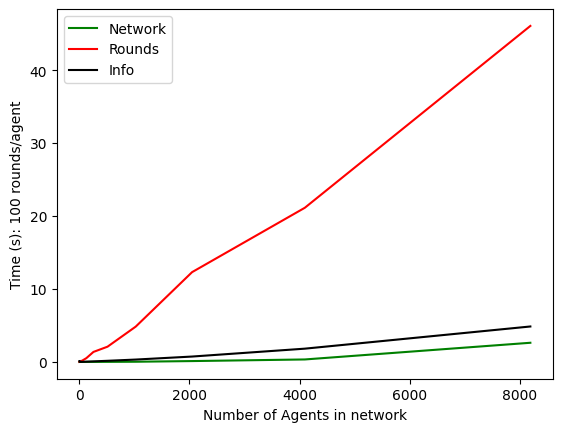

In [65]:
plt.plot([2,4,8,16,32,64,128,256,512,1024,2048,4096,8192],n_time,color='green',label='Network')
plt.plot([2,4,8,16,32,64,128,256,512,1024,2048,4096,8192],r_time,color='red',label='Rounds')
plt.plot([2,4,8,16,32,64,128,256,512,1024,2048,4096,8192],s_time,color='black',label='Info')

plt.legend()
#plt.ylim(-15,515)
plt.xlabel('Number of Agents in network')
plt.ylabel('Time (s): 100 rounds/agent')
plt.show()

In [5]:
# Simulate several networks
n_rounds= 50
n_sims = 25
dicts = [round(x*.1 + 0.1,1) for x in range(0,8)]
df = pd.DataFrame({'ID':[],'Jaccard':[],'Average':[],'Med':[],'Agents':[],'Dict':[],'Network':[]})

start = time.time()
for network_type in ['Fully','Centralized']:
    print(network_type, '- Total Time - ',time.time() - start)
    for d in range(len(dicts)):
        now = time.time()
        # Create a zipf dictionary with specified degree of bias
        all_words = [str(i) for i in range(5000)]
        zipf_probs = []
        for w in range(len(all_words)):
            word = all_words[w]
            zipf_probs.append((w+1)**-dicts[d])
        total = sum(zipf_probs)
        for w in range(len(zipf_probs)):
            zipf_probs[w] = zipf_probs[w] / total

        # Create networks with different numbers of agents
        for n_agents in [10,100,1000,10000]:
            now_2 = time.time()
            n_id, n_words, n_avg, n_med = [],[],[],[]
            
            # Run simulations with the specified number of rounds
            test = Network(n_agents,m=2,dmin=.01,dictionary=all_words,weights=zipf_probs)
            if network_type == 'Fully':
                test.fully_connected()
            elif network_type == 'Centralized':
                test.centralized()
            
            for s in range(n_sims):
                test.cur_sim=s
                for i in range(n_rounds):
                    test.play_round_all()
                df_info = test.get_data()
                df_info = df_info.loc[df_info.Sim_N == s]
                n_id.append(s)
                
                # Calculate the median number of words heard
                #says = df_info.groupby("Speaker").apply(lambda x: x.Said.unique())
                #hears = df_info.groupby("Hearer").apply(lambda x: x.Said.unique())
                #all_ws = [len(set(list(says[i]) + list(hears[i]))) for i in range(len(says))]
                #n_avg.append(sum(all_ws) / len(all_ws))

                # Top 5 words for finding Jaccard distance
                vocab = []
                for a in test.agents_labs.values():
                    vocab = vocab + [l[0] for l in a]
                c = Counter(vocab)
                n_words.append(list(set([i[0] for i in c.most_common(5)])))


                # Reset network - Necessary if you put the network out of the loop
                test.agents_cats = []
                test.agents_labs = []
                test.agents_successes = []
                test.agents_cats = {f"A_{i}": [max(test.continuum)] for i in range(test.n_agents)}
                test.agents_labs = {f"A_{i}": [[]] for i in range(test.n_agents)}
                test.agents_successes = {f"A_{i}": [[]] for i in range(test.n_agents)}
                
            print('Agents:',n_agents,'Dict:',dicts[d],'Time:',time.time() - now_2)

                
            jac = get_jaccard(n_words)
            df_current = pd.DataFrame({'ID':n_id,'Jaccard':jac})#,'Average':n_avg,'Med':n_med})
            df_current['Agents'] = n_agents
            df_current['Dict'] = dicts[d]
            df_current['Network'] = network_type
            df = pd.concat([df,df_current])
        print('Dict:',dicts[d],'Time:',time.time() - now,'\n')

Fully - Total Time -  0.0005469322204589844
Agents: 10 Dict: 0.1 Time: 1.197303056716919
Agents: 100 Dict: 0.1 Time: 10.770075798034668
Agents: 1000 Dict: 0.1 Time: 145.29524302482605
Agents: 10000 Dict: 0.1 Time: 2471.705466747284
Dict: 0.1 Time: 2629.122936964035 

Agents: 10 Dict: 0.2 Time: 8.604949951171875
Agents: 100 Dict: 0.2 Time: 14.756526708602905
Agents: 1000 Dict: 0.2 Time: 172.50273728370667
Agents: 10000 Dict: 0.2 Time: 2713.8251028060913
Dict: 0.2 Time: 2909.873939037323 

Agents: 10 Dict: 0.3 Time: 7.956738233566284
Agents: 100 Dict: 0.3 Time: 13.003551959991455
Agents: 1000 Dict: 0.3 Time: 175.87688183784485
Agents: 10000 Dict: 0.3 Time: 2865.874454975128
Dict: 0.3 Time: 3062.822507619858 

Agents: 10 Dict: 0.4 Time: 7.101329803466797
Agents: 100 Dict: 0.4 Time: 16.864993810653687
Agents: 1000 Dict: 0.4 Time: 204.83429622650146
Agents: 10000 Dict: 0.4 Time: 2609.9882917404175
Dict: 0.4 Time: 2838.8936927318573 

Agents: 10 Dict: 0.5 Time: 7.0272040367126465
Agents: 100

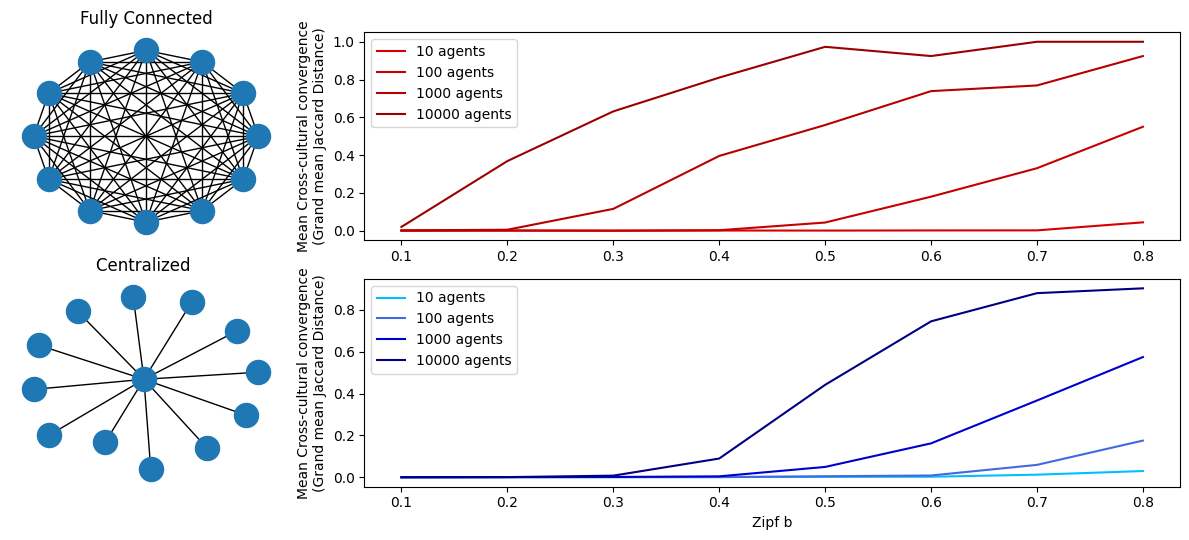

In [7]:
# Group df by dictionary size, then plot
jacs_1, jacs_2 = [[] for i in range(4)],[[] for i in range(4)]
labs = []
ags = [10,100,1000,10000]
for i in range(len(ags)):
    j = ags[i]
    labs.append(str(j) + ' agents')
    df_t = df.loc[df.Agents == j]
    for d in dicts:
        df_temp = df_t.loc[df_t.Dict == d]
        jacs_1[i].append(df_temp.loc[df_temp.Network == 'Fully'].Jaccard.mean())
        jacs_2[i].append(df_temp.loc[df_temp.Network == 'Centralized'].Jaccard.mean())

# Plot these on two figures in two separate rows
fig, axs = plt.subplots(2, 2, figsize=(12, 5.5),gridspec_kw={'width_ratios': [1, 3]})
n_agents = 12

# Plot the network ==============================
# Fully connected
G = nx.complete_graph(n_agents)
nx.draw(G,ax=axs[0,0],pos=nx.circular_layout(G))
axs[0,0].set_title('Fully Connected')
# Centralized
G = nx.star_graph(n_agents)
nx.draw(G,ax=axs[1,0])
axs[1,0].set_title('Centralized ')


# Plot the results ==============================
reds = ['#d70000','#c60000','#b70000','#9b0000','#8b0000']
blues = ['#00bfff','#4169e1','#0000cd','#000080','#00008b']
for i in range(len(reds)-1):
    axs[0,1].plot(dicts,jacs_1[i],'-',color=reds[i],label=labs[i])
    axs[1,1].plot(dicts,jacs_2[i],'-',color=blues[i],label=labs[i])


axs[0,1].set_ylabel('Mean Cross-cultural convergence\n(Grand mean Jaccard Distance)')
axs[1,1].set_ylabel('Mean Cross-cultural convergence\n(Grand mean Jaccard Distance)')
axs[0,1].legend()
axs[1,1].legend()
axs[1,1].set_xlabel('Zipf b')

plt.tight_layout()
plt.show()

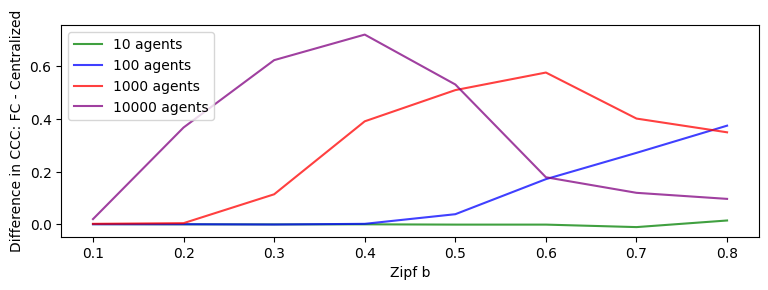

In [10]:
# Plot these on two figures in two separate rows
fig, axs = plt.subplots(1, 1, figsize=(9, 2.75))

# Plot the results ==============================
reds = ['#d70000','#c60000','#b70000','#9b0000']
blues = ['#00bfff','#4169e1','#0000cd','#000080']
colors = ['green','blue','red','purple','black']
for i in range(len(colors)-1):
    jacs = []
    for j in range(len(jacs_1[i])):
        jacs.append(jacs_1[i][j] - jacs_2[i][j])
    axs.plot(dicts,jacs,'-',color=colors[i],label=labs[i],alpha=0.75)

axs.set_ylabel('Difference in CCC: FC - Centralized')
#axs.set_ylim(-.08,1.08)
axs.legend()
axs.set_xlabel('Zipf b')
plt.show()

In [57]:
jacs_1

[[0.00037037037037037035,
  0.0,
  0.00037037037037037035,
  0.0007407407407407407,
  0.0022222222222222222,
  0.0011111111111111111,
  0.022037037037037042,
  0.022037037037037042],
 [0.00037037037037037035,
  0.00037037037037037035,
  0.0007407407407407407,
  0.0011111111111111111,
  0.0037037037037037034,
  0.045740740740740755,
  0.18031746031746035,
  0.2623677248677248],
 [0.0011111111111111111,
  0.0007407407407407407,
  0.0011111111111111111,
  0.006296296296296296,
  0.025370370370370366,
  0.1385185185185186,
  0.38705026455026453,
  0.5037698412698411]]

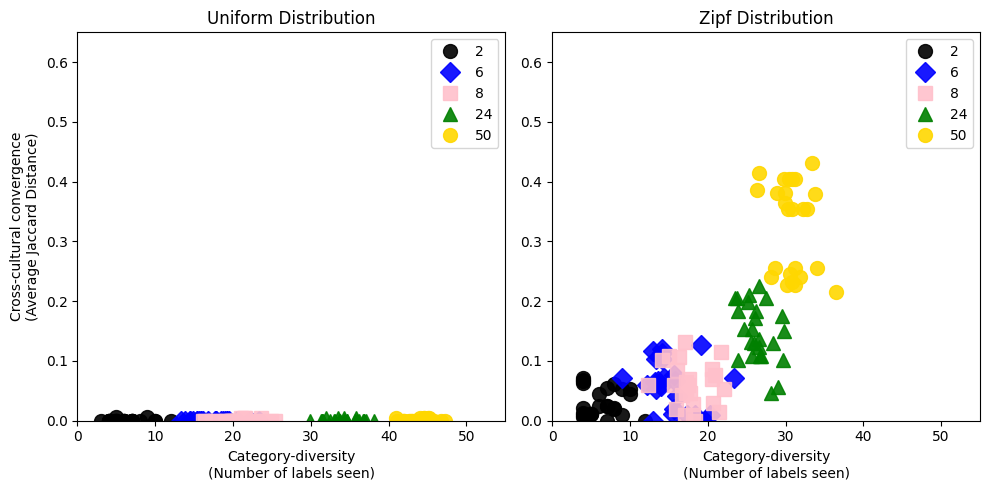

In [27]:
# Simulate several networks
n_rounds= 50
n_sims = 25
dicts = [uniform_probs, zipf_probs]
df = pd.DataFrame({'ID':[],'Jaccard':[],'Average':[],'Agents':[],'Dict':[]})
for d in range(len(dicts)):
    for n_agents in [2,6,8,24,50]:
        print(n_agents)
        n_id, n_words, n_avg = [],[],[]
        test = Network(n_agents,m=2,dmin=.01,dictionary=all_words,weights=dicts[d])
        test.fully_connected()
        for s in range(n_sims):
            test.cur_sim=s
            for i in range(n_rounds):
                test.play_round_all()
            df_info = test.get_data()
            df_info = df_info.loc[df_info.Sim_N == s]
            n_id.append(s)
            
            says = df_info.groupby("Speaker").apply(lambda x: x.Said.unique())
            hears = df_info.groupby("Hearer").apply(lambda x: x.Said.unique())
            all_ws = [len(set(list(says[i]) + list(hears[i]))) for i in range(len(says))]
            n_avg.append(sum(all_ws) / len(all_ws))

            # Top 5 words
            vocab = []
            for a in test.agents_labs.values():
                vocab = vocab + [l[0] for l in a]
            c = Counter(vocab)
            n_words.append(list(set([i[0] for i in c.most_common(5)])))
            
            # Reset network
            test.agents_cats = []
            test.agents_labs = []
            test.agents_successes = []
            for i in range(test.n_agents):
                test.agents_cats = {f"A_{i}": [max(test.continuum)] for i in range(test.n_agents)}
                test.agents_labs = {f"A_{i}": [[]] for i in range(test.n_agents)}
                test.agents_successes = {f"A_{i}": [[]] for i in range(test.n_agents)}
            
        jac = get_jaccard(n_words)
        df_current = pd.DataFrame({'ID':n_id,'Jaccard':jac,'Average':n_avg})
        df_current['Agents'] = n_agents
        df_current['Dict'] = d
        df = pd.concat([df,df_current])

m = 10
a = 0.9
fig, axs = plt.subplots(1,2,figsize=(10,5))


df_temp = df.loc[df.Dict == 0]
axs[0].plot(df_temp.loc[df_temp.Agents==2].Average,df_temp.loc[df_temp.Agents==2].Jaccard,'o',color='black',ms=m,alpha=a,label='2')
axs[0].plot(df_temp.loc[df_temp.Agents==6].Average,df_temp.loc[df_temp.Agents==6].Jaccard,'D',color='blue',ms=m,alpha=a,label='6')
axs[0].plot(df_temp.loc[df_temp.Agents==8].Average,df_temp.loc[df_temp.Agents==8].Jaccard,'s',color='pink',ms=m,alpha=a,label='8')
axs[0].plot(df_temp.loc[df_temp.Agents==24].Average,df_temp.loc[df_temp.Agents==24].Jaccard,'^',color='green',ms=m,alpha=a,label='24')
axs[0].plot(df_temp.loc[df_temp.Agents==50].Average,df_temp.loc[df_temp.Agents==50].Jaccard,'o',color='gold',ms=m,alpha=a,label='50')
axs[0].set_ylabel('Cross-cultural convergence\n(Average Jaccard Distance)')
axs[0].set_xlabel('Category-diversity\n(Number of labels seen)')
axs[0].set_title('Uniform Distribution')
axs[0].set_ylim(0,0.65)
axs[0].set_xlim(0,55)
axs[0].legend()

df_temp = df.loc[df.Dict == 1]
axs[1].plot(df_temp.loc[df_temp.Agents==2].Average,df_temp.loc[df_temp.Agents==2].Jaccard,'o',color='black',ms=m,alpha=a,label='2')
axs[1].plot(df_temp.loc[df_temp.Agents==6].Average,df_temp.loc[df_temp.Agents==6].Jaccard,'D',color='blue',ms=m,alpha=a,label='6')
axs[1].plot(df_temp.loc[df_temp.Agents==8].Average,df_temp.loc[df_temp.Agents==8].Jaccard,'s',color='pink',ms=m,alpha=a,label='8')
axs[1].plot(df_temp.loc[df_temp.Agents==24].Average,df_temp.loc[df_temp.Agents==24].Jaccard,'^',color='green',ms=m,alpha=a,label='24')
axs[1].plot(df_temp.loc[df_temp.Agents==50].Average,df_temp.loc[df_temp.Agents==50].Jaccard,'o',color='gold',ms=m,alpha=a,label='50')
# Add a lowess line to the plot

axs[1].set_ylim(0,0.65)
axs[1].set_xlim(0,55)
axs[1].set_xlabel('Category-diversity\n(Number of labels seen)')
axs[1].legend()
axs[1].set_title('Zipf Distribution')
plt.tight_layout()
plt.show()

In [22]:
# 2023-01-31 Midday

# Create a class that contains a network of agents
class Network():

    def __init__(self, n_agents, continuum=[0,1],cur_sim = 0, dmin=0.1,m=2,dictionary=5000,weights=5000):
        self.n_agents = n_agents
        self.continuum = continuum
        self.dmin = dmin
        self.M = m
        self.cur_sim = cur_sim
        
        if dictionary != None:
            self.dictionary = dictionary
            self.weights = weights
        else:
            self.dictionary = [str(i) for i in range(dictionary)]
            self.weights = [1/weights for i in range(weights)]
        self.neighbors = []

        
        self.agents = []
        self.agents_cats = []
        self.agents_labs = []
        self.agents_successes = []
        self.agents_neigh = []
        
        self.speakers = []
        self.sim_n = []
        self.hearers = []
        self.scenes = []
        self.topics = []
        self.said = []
        self.hearer_guesses = []
        self.outcomes = []


    # At each time step, a pair of individuals (one playing as speaker and the other as hearer) is selected and presented with a new “scene”: i.e., a set of M ≥ 2 objects
    def play_round(self):
        
        # Select a random agent to be the speaker and a hearrer from their neighbors
        speaker = random.randint(0, self.n_agents - 1)
        hearer = int(random.choice(self.agents_neigh[speaker])[2:])
        
        # Generate the scene of M objects at least dmin apart
        scene = []
        while len(scene) < self.M:
            object = random.random() * max(self.continuum)
            good = True
            for i in range(len(scene)):
                if abs(object - scene[i]) < self.dmin:
                    good = False
                    break
            if good:
                scene.append(object)
        scene.sort()
        topic = random.choice(scene)
        
        # The speaker starts by discriminating the scene, 
        self.descriminate(scene, topic, speaker)
        
        # Return the last successfuul label OR the new word as per "word transmission"
        cat = bisect(self.agents_cats[speaker], topic)
        if 1 in self.agents_successes[speaker][cat]:
            word = self.agents_labs[speaker][cat][-1] # The success will always be the last word in the list
        else:
            word = self.agents_labs[speaker][cat][0]
        
        # Word reception: The hearer receives the transmitted word, and b looking at its repertoire, identifies the set of all categories
        #     (i) whose inventories contain the transmitted word and
        #     (ii) that are associated to at least one stimulus in the scene
        categories_scene = [bisect(self.agents_cats[hearer], c) for c in scene]
        indices = list(set([i for i, x in enumerate(self.agents_labs[hearer]) if word in x]) & set(categories_scene))
        success = False
        if len(indices) > 0:
            # The hearer selects an index at random and returns the associated item from the scene
            guess = scene[categories_scene.index(random.choice(indices))]
            self.hearer_guesses.append(guess)
            if guess == topic:
                success = True
        else:
            self.hearer_guesses.append(None)
        
        # Updating the logs
        self.speakers.append(self.agents[speaker])
        self.hearers.append("A_"+str(hearer))
        self.scenes.append(scene)
        self.topics.append(topic)
        self.said.append(word)
        self.outcomes.append(success)
        self.sim_n.append(self.cur_sim)
        
        # Updating. Independent of the outcome of the game, the hearer checks whether the topic is discriminated by one of its categories. If not, she discriminates the topic.
        self.descriminate(scene, topic, hearer)

        
        # in case of success both agents delete all the other words but the transmitted one from the inventories of the categories that discriminate the topic.
        if success:
            self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)] = [word]
            self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)] = [1]
            self.agents_labs[speaker][bisect(self.agents_cats[speaker], topic)] = [word]
            self.agents_successes[speaker][bisect(self.agents_cats[speaker], topic)] = [1]
        # in case of failure the hearer adds the transmitted word to the category discriminating the topic;
        else:
            self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)] = [word] + self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)]
            self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)] = [0] + self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)]


    # Identical to play-round but exhausts list (in random order) of agents and randomly chooses partner from the neighbors, randomly assigns roles.
    def play_round_all(self):
        
        # Different part: iterate through all agents, randomly select neighbor, randomly assign roles
        all_rand = [i for i in range(self.n_agents)]
        random.shuffle(all_rand)
        for s in all_rand:
            h = int(random.choice(self.agents_neigh[s])[2:])
            pair = [s,h]
            random.shuffle(pair)
            speaker = pair[0]
            hearer = pair[1]
        
            # Same as play_round
            scene = set()
            while len(scene) < 3:
                object = random.random() 
                if all(abs(object - other) >= 0.1 for other in scene):
                    scene.add(object)
            scene = sorted(scene)
            topic = random.choice(scene)
            self.descriminate(scene, topic, speaker)
            cat = bisect(self.agents_cats[speaker], topic)
            if 1 in self.agents_successes[speaker][cat]:
                word = self.agents_labs[speaker][cat][-1] # The success will always be the last word in the list
            else:
                word = self.agents_labs[speaker][cat][0]
            categories_scene = [bisect(self.agents_cats[hearer], c) for c in scene]
            indices = list(set([i for i, x in enumerate(self.agents_labs[hearer]) if word in x]) & set(categories_scene))
            success = False
            if len(indices) > 0:
                guess = scene[categories_scene.index(random.choice(indices))]
                self.hearer_guesses.append(guess)
                if guess == topic:
                    success = True
            else:
                self.hearer_guesses.append(None)
            self.speakers.append(self.agents[speaker])
            self.hearers.append("A_"+str(hearer))
            self.scenes.append(scene)
            self.topics.append(topic)
            self.said.append(word)
            self.outcomes.append(success)
            self.sim_n.append(self.cur_sim)
            self.descriminate(scene, topic, hearer)
            if success:
                self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)] = [word]
                self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)] = [1]
                self.agents_labs[speaker][bisect(self.agents_cats[speaker], topic)] = [word]
                self.agents_successes[speaker][bisect(self.agents_cats[speaker], topic)] = [1]
            else:
                self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)] = [word] + self.agents_labs[hearer][bisect(self.agents_cats[hearer], topic)]
                self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)] = [0] + self.agents_successes[hearer][bisect(self.agents_cats[hearer], topic)]


    # Descriminate scene if necessary, adding new category boundaries to isolate the topic; then she labels one object and the hearer tries to guess it
    # Each new categoryinherits the linguistic inventory of C, plus a new word.   
    def descriminate(self,scene, topic, person):
        categories_scene = [bisect(self.agents_cats[person], c) for c in scene]
        if len(set(categories_scene)) == len(categories_scene):
            return # The topic is already descriminated

        # If the topic is the smallest, and doesn't descriminate, add a new category halfway between it and second with the same labels
        if scene.index(topic) == 0:
            if categories_scene[0] == categories_scene[1]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2) # Change here (and all other casaes of word_1) previously random.choices produced one unique item for word_1 and word_2 separately
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[0], (scene[0]+scene[1])/2)
                self.agents_labs[person].insert(categories_scene[0],[word_1] + self.agents_labs[person][categories_scene[0]])
                self.agents_successes[person].insert(categories_scene[0],[0] + self.agents_successes[person][categories_scene[0]])
                self.agents_labs[person][categories_scene[0]+1] = [word_2] + self.agents_labs[person][categories_scene[0]+1]
                self.agents_successes[person][categories_scene[0]+1] = [0] + self.agents_successes[person][categories_scene[0]+1]

        # If the topic is the largest, and doesn't descriminate, add a new category halfway between it and second to last with the same labels
        if scene.index(topic) == len(scene) - 1:
            if categories_scene[-1] == categories_scene[-2]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2)
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[-1], (scene[-1]+scene[-2])/2)
                self.agents_labs[person].insert(categories_scene[-1],[word_1] + self.agents_labs[person][categories_scene[-1]])
                self.agents_successes[person].insert(categories_scene[-1],[0] + self.agents_successes[person][categories_scene[-1]])
                self.agents_labs[person][categories_scene[-1]+1] = [word_2] + self.agents_labs[person][categories_scene[-1]+1]
                self.agents_successes[person][categories_scene[-1]+1] = [0] + self.agents_successes[person][categories_scene[-1]+1]
        
        # if the topic is in the middle, and doesn't descriminate, add a new category halfway between it and the undescriminated partners with the same labels
        if scene.index(topic) > 0 and scene.index(topic) < len(scene) - 1:
            # If need to descriminate twice, update twice
            if (categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)-1]) and (categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)+1]):
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=3)
                    if len(set(pos_words)) == 3 : 
                        word_1, word_2, word_3 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)+1])/2)
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)-1])/2)
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]])
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]+1])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],[0] + self.agents_successes[person][categories_scene[scene.index(topic)]])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],[0] + self.agents_successes[person][categories_scene[scene.index(topic)]+1])
                self.agents_labs[person][categories_scene[scene.index(topic)]+2] = [word_3] + self.agents_labs[person][categories_scene[scene.index(topic)]]  
                self.agents_successes[person][categories_scene[scene.index(topic)]+2] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]+1] = [word_2] + self.agents_labs[person][categories_scene[scene.index(topic)]]  
                self.agents_successes[person][categories_scene[scene.index(topic)]+1] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]] = [word_1] + self.agents_labs[person][categories_scene[scene.index(topic)]]  
                self.agents_successes[person][categories_scene[scene.index(topic)]] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
        
            # If need to descriminate once, update once
            elif categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)-1]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2)
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)-1])/2)
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],[0] + self.agents_successes[person][categories_scene[scene.index(topic)]])
                self.agents_labs[person][categories_scene[scene.index(topic)]+1] = [word_2] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]+1] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]] = [word_1] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
            elif categories_scene[scene.index(topic)] == categories_scene[scene.index(topic)+1]:
                unique = 0
                while unique == 0: 
                    pos_words = random.choices(self.dictionary, self.weights,k=2)
                    if len(set(pos_words)) == 2 : 
                        word_1, word_2 = pos_words
                        unique=1
                self.agents_cats[person].insert(categories_scene[scene.index(topic)], (scene[scene.index(topic)]+scene[scene.index(topic)+1])/2)
                self.agents_labs[person].insert(categories_scene[scene.index(topic)],self.agents_labs[person][categories_scene[scene.index(topic)]])
                self.agents_successes[person].insert(categories_scene[scene.index(topic)],self.agents_successes[person][categories_scene[scene.index(topic)]])
                self.agents_labs[person][categories_scene[scene.index(topic)]+1] = [word_2] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]+1] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]
                self.agents_labs[person][categories_scene[scene.index(topic)]] = [word_1] + self.agents_labs[person][categories_scene[scene.index(topic)]]
                self.agents_successes[person][categories_scene[scene.index(topic)]] = [0] + self.agents_successes[person][categories_scene[scene.index(topic)]]


    # Synonymy is a measure of the average number of words per perceptual category
    def get_synonymy(self):
        synonymy = []
        for a in range(len(self.agents)):
            synonymy.append(sum([len(i) for i in self.agents_labs[a]]) / len(self.agents_cats[a]))
        return(sum(synonymy)/len(synonymy))
    
    def get_categories(self):
        cats = []
        for a in range(len(self.agents)):
            cats.append(len(self.agents_cats[a]))
        return(sum(cats)/len(cats))
    
    def get_linguistic_categories(self):
        cats = []
        for a in range(len(self.agents)):
            cats.append(len(list(set([l[0] for l in self.agents_labs[a]]))))
        return(sum(cats)/len(cats))
    
    def get_perceptual_alignment(self):
        align = []
        obs = self.agents
        # Pair every agent with every other agent once
        for a in range(int(len(obs)-1)):
            a_1 = [0]+ self.agents_cats[a]
            for j in range(len(obs)-a-1):
                a_2 = [0]+ self.agents_cats[a+j+1]
                # Create a new agent that has all the categories
                a_3 = copy.deepcopy(a_1)
                [a_3.append(i) for i in a_2]
                a_3 = list(set(a_3))
                a_3.sort()
                # Perform the equation on these categories
                a1,a2,a3 = 0,0,0
                for i in range(len(a_1)-1):
                    a1 = a1 + (a_1[i+1] - a_1[i])**2
                for i in range(len(a_2)-1):
                    a2 = a2 + (a_2[i+1] - a_2[i])**2
                for i in range(len(a_3)-1):
                    a3 = a3 + (a_3[i+1] - a_3[i])**2
                align.append((2*a3)/(a1+a2))
        return((2* sum(align)) / (len(obs)*(len(obs)-1)))
            
    def get_linguistic_alignment(self):
        align = []
        obs = self.agents
        # Pair every agent with every other agent once
        for a in range(len(obs)-1):
            al_1 = self.agents_labs[a]
            # Get linguistic categories - first item associated with each perceptual category
            a_1 = [l[0] for l in al_1]
            al_1 = []
            # For each unique item, return last occurence index
            for i in list(set(a_1)):
                al_1.append(len(a_1) - 1 - a_1[::-1].index(i))
            # Get the perceptual category limit associated with each of these and create a composite agent
            a_1 = [0] + [self.agents_cats[a][l] for l in al_1]
            a_1.sort()
            for j in range(len(obs)-a-1):
                al_2 = self.agents_labs[a+j+1]
                a_2 = [l[0] for l in al_2]
                al_2 = []
                for i in list(set(a_2)):
                    al_2.append(len(a_2) - 1 - a_2[::-1].index(i))
                a_2 = [0] + [self.agents_cats[a+j+1][l] for l in al_2]    
                a_2.sort()
                a_3 = copy.deepcopy(a_1)
                [a_3.append(i) for i in a_2]
                a_3 = list(set(a_3))
                a_3.sort()
                # Get the alignment just like we did for the conceptual category
                a1,a2,a3 = 0,0,0
                for i in range(len(a_1)-1):
                    a1 = a1 + (a_1[i+1] - a_1[i])**2
                for i in range(len(a_2)-1):
                    a2 = a2 + (a_2[i+1] - a_2[i])**2
                for i in range(len(a_3)-1):
                    a3 = a3 + (a_3[i+1] - a_3[i])**2
                align.append((2*a3)/(a1+a2))
        return((2* sum(align)) / (len(obs)*(len(obs)-1)))


    # Return a dataframe with all of the rounds played
    def get_data(self):
        return pd.DataFrame({'Speaker':self.speakers, 'Hearer':self.hearers, 'Scene':self.scenes, 'Topic':self.topics, 'Said':self.said, 
                                'Hearer_guesses':self.hearer_guesses, 'Outcome':self.outcomes,'Sim_N':self.sim_n})

     # Types of networks
    def fully_connected(self):
        # All players are created with only the trivial perceptual category [0,1], with no label associated to it
        for i in range(self.n_agents):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(i))
        for i in range(self.n_agents):
            self.agents_neigh.append(self.agents[:i]+self.agents[i+1:])
            #self.agents_neigh.append([])
            #for j in range(self.n_agents):
            #    if i != j:
            #        self.agents_neigh[i].append(self.agents[j])

    def centralized(self):
        for i in range(self.n_agents):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(i))
        self.agents_neigh.append(self.agents[1:])
        for i in range(self.n_agents -1):
            self.agents_neigh.append([self.agents[0]])
            
    def from_nx(self, G):
        for i in list(G):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(i))
            self.agents_neigh.append([])
        for i in list(G):
            for n in G.neighbors(i):
                self.agents_neigh[i].append(self.agents[n])


    def lattice(self,n_connections = 2):
        for i in range(self.n_agents):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(i))
        for j in range(self.n_agents):
            neighs = []
            for i in range(n_connections):
                neighs.append(self.agents[j-n_connections+i])
            for i in range(n_connections):
                neighs.append(self.agents[(j+i+1) % self.n_agents])
            self.agents_neigh.append(neighs)

    # Takes a erdos renyi graph and adds n_centers agents who are connected to all other agents with probability connect_probs
    def central_erdos_renyi(self, n_centers, connect_probs_edges = 0.1, connect_probs_center = 1):
        G = nx.erdos_renyi_graph(self.n_agents - n_centers, connect_probs_edges)
        self.from_nx(G)
        for i in range(n_centers):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(len(self.agents)))
            self.agents_neigh.append([])
            for j in range(self.n_agents - n_centers + i):
                if  random.random() < connect_probs_center:
                    self.agents_neigh[-1].append(self.agents[j])
                    self.agents_neigh[j].append(self.agents[-1])

    # To begin our study of modularity, let's create segregated groups of agents
    def segregated_groups(self, n_members = 2):
        for i in range(self.n_agents):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(i))
            self.agents_neigh.append([])
        
        m = 0
        for i in range(int(round(self.n_agents/n_members,0))):
            for j in range(n_members):
                for k in range(n_members):
                    if j != k:
                        self.agents_neigh[(i * n_members)+j].append(self.agents[(i * n_members)+k])


    def random_same_edges(self, n_connections = 2):
        for i in range(self.n_agents):
            self.agents_cats.append([max(self.continuum)])
            self.agents_labs.append([[]])
            self.agents_successes.append([[]])
            self.agents.append("A_"+str(i))
            self.agents_neigh.append([])
        
        # Put every agent in a list n_connections times
        connections = []
        for i in range(self.n_agents):
            for j in range(n_connections):
                connections.append(i)
        random.shuffle(connections)

        # randomly draw n_connections items from connections as potential neighbors, along with an agent (a)
        
        while (len(connections) > 1):
            if len(connections) == 2:
                a = connections.pop(0)
                c = connections.pop(0)
                self.agents_neigh[a].append(self.agents[c])
                self.agents_neigh[c].append(self.agents[a])
            
            else:
                a = connections.pop(0)
                # determine how many neighbors that agent needs
                n_c = n_connections - len(self.agents_neigh[a])
                for j in range(n_c-1):
                    connections.remove(a)
            
                # Determine if they are unique and different from a. If not, reshuffle until they are, then add the neighbors to the graph
                u_d = True
                if len(np.unique(connections) < n_c):
                    u_d = False
                try:
                    candidates = random.sample(connections, k=n_c)
                except:
                    print('Bad 1',candidates, connections, n_c)
                m = 0
                while u_d:
                    m += 1
                    if m > 50: # Sometimes it's not possible to get a perfect match, so settle for this: ERROR
                        for c in candidates:
                            if a == c:
                                next
                            elif c in self.agents_neigh[a]:
                                next
                            else:
                                
                                self.agents_neigh[a].append(self.agents[c])
                                self.agents_neigh[c].append(self.agents[a])
                        break
                    u_d = False
                    if a in candidates:
                        candidates = random.sample(connections, k=n_c)
                        u_d = True
                    elif len(np.unique(candidates)) != len(candidates):
                        candidates = random.sample(connections, k=n_c)
                        u_d = True
                    else:
                        for c in candidates:
                            if c in self.agents_neigh[a]:
                                candidates = random.sample(connections, k=n_c)
                                u_d = True
                                break
                for c in candidates:
                    try: 
                        connections.remove(c)
                        self.agents_neigh[a].append(self.agents[c])
                        self.agents_neigh[c].append(self.agents[a])
                    except:
                        print('BAD 2',connections,candidates,a,c,n_c)
            

    def get_edges(self):
        from_, to_ = [],[]
        for i in range(self.n_agents):
            for j in range(len(self.agents_neigh[i])):
                from_.append(self.agents[i])
                to_.append(self.agents_neigh[i][j])
        return pd.DataFrame({'From':from_, 'To':to_})
